In [1]:
from proxbias.depmap.process import compute_monte_carlo_stats
from proxbias.depmap.load import get_depmap_data
from proxbias.utils.data_utils import get_cancer_gene_lists
from proxbias.metrics import genome_proximity_bias_score
from proxbias.depmap.constants import *

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import pickle
import ast
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
crispr_effect, _, cnv_data, mutation_data = get_depmap_data(rnai_release="")
oncogenes, tsgs = get_cancer_gene_lists(crispr_effect.index)

CRISPRGeneEffect.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!
OmicsCNGene.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!
OmicsSomaticMutations.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!


In [4]:
%%time
# Note - n_workers should likely be around half the number of CPUs
res = compute_monte_carlo_stats(
    genes_of_interest=["TP53"],
    dependency_data=crispr_effect,
    cnv_data=cnv_data,
    mutation_data=mutation_data,
    candidate_models=list(crispr_effect.columns),
    search_mode="lof",
    n_iterations=100,
    eval_function=genome_proximity_bias_score,
    eval_kwargs={"n_samples": 500, "n_trials": 200, "return_samples": False},
    n_workers=4,
    cnv_cutoffs=(1.75, 2.25)
)

Stats for TP53 computed in 169.81743693351746 - diff is 0.04008458619999988, 200 wt and 444 lof
CPU times: user 290 ms, sys: 156 ms, total: 446 ms
Wall time: 2min 51s


In [5]:
res.head()

,test_stats,test_mean,wt_stats,wt_mean,diff,search_mode,n_models,n_test,n_wt
TP53,"[0.67238148, 0.66245808, 0.6586740799999999, 0...",0.667355,"[0.63087722, 0.6287808799999999, 0.632288, 0.6...",0.627271,0.040085,lof,160,444,200


In [6]:
#write a function that performs a t-test for the bootstrap estimates
def perform_t_test(df: pd.DataFrame) -> pd.DataFrame:
    df = df.reset_index().rename(columns={'index': 'gene'})

    # Initialize t_stat and p_value columns in the original DataFrame
    df['t_stat'] = None
    df['p_value'] = None

    for index, row in df.iterrows():
        test_stats = row['test_stats']
        wt_stats = row['wt_stats']

        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(test_stats, wt_stats)
        
        # Assign t_stat and p_value to the respective columns in the DataFrame
        df.at[index, 't_stat'] = t_stat
        df.at[index, 'p_value'] = p_value
    
    return df
pd.options.display.float_format = '{:.10e}'.format
ttest=perform_t_test(res)
ttest

,gene,test_stats,test_mean,wt_stats,wt_mean,diff,search_mode,n_models,n_test,n_wt,t_stat,p_value
0,TP53,"[0.67238148, 0.66245808, 0.6586740799999999, 0...",6.6735532760e-01,"[0.63087722, 0.6287808799999999, 0.632288, 0.6...",6.2727074140e-01,4.0084586200e-02,lof,160,444,200,4.6508027813e+01,1.6043252872e-108


In [16]:
# Write a function that scrambles the ModelID column name so that it is disconnected from the mutation type
def scramble_column(df: pd.DataFrame, column_name: str = 'ModelID', seed: int = None) -> pd.DataFrame:
    scrambled_df = df.copy()
    
    # Check if the specified column is in the DataFrame
    if column_name in scrambled_df.columns:
        # Extract the specified column
        column_values = scrambled_df[column_name].tolist()
    else:
        # Extract the index if the column is not a regular column
        column_values = scrambled_df.index.tolist()
    
    # Shuffle the column values list with the specified seed
    if seed is not None:
        random.seed(seed)
    random.shuffle(column_values)
    
    # Assign the scrambled column values list back to the DataFrame
    if column_name in scrambled_df.columns:
        scrambled_df[column_name] = column_values
    else:
        scrambled_df.index = column_values
    
    return scrambled_df

# Example usage
# Assuming crispr_effect is a DataFrame
scrambled_cnv_data = scramble_column(cnv_data, seed=60)
scrambled_cnv_data


ModelID,ACH-002677,ACH-000238,ACH-002806,ACH-000967,ACH-001696,ACH-000431,ACH-000979,ACH-000818,ACH-000422,ACH-000919,...,ACH-000516,ACH-002248,ACH-002370,ACH-002213,ACH-000970,ACH-000379,ACH-002306,ACH-000477,ACH-002197,ACH-000199
NEK7,1.0169170477e+00,1.0252245991e+00,9.5921757667e-01,1.0048317811e+00,6.7810472391e-01,9.1587460915e-01,7.2648453903e-01,5.4303496554e-01,1.2173390166e+00,9.8155907240e-01,...,1.0654596811e+00,4.9212646253e-01,1.0094517821e+00,7.4180710958e-01,9.7031360077e-01,8.9828802085e-01,1.0507889978e+00,7.9915153620e-01,5.1559136246e-01,9.9457908628e-01
MIR5187,1.0169170477e+00,1.0252245991e+00,9.5921757667e-01,1.0048317811e+00,6.7810472391e-01,9.1587460915e-01,7.2648453903e-01,5.4303496554e-01,1.2173390166e+00,9.8155907240e-01,...,1.0654596811e+00,4.9212646253e-01,1.0094517821e+00,7.4180710958e-01,9.7031360077e-01,8.9828802085e-01,1.0507889978e+00,7.9915153620e-01,5.1559136246e-01,9.9457908628e-01
PPP1R26-AS1,1.0169170477e+00,1.0252245991e+00,9.5921757667e-01,1.0048317811e+00,6.7810472391e-01,9.1587460915e-01,7.2648453903e-01,5.4303496554e-01,1.2173390166e+00,9.8155907240e-01,...,1.0654596811e+00,4.9212646253e-01,1.0094517821e+00,7.4180710958e-01,9.7031360077e-01,8.9828802085e-01,1.0507889978e+00,7.9915153620e-01,5.1559136246e-01,9.9457908628e-01
CD200R1L,1.0169170477e+00,1.0252245991e+00,9.5921757667e-01,1.0048317811e+00,6.7810472391e-01,9.1587460915e-01,7.2648453903e-01,5.4303496554e-01,1.2173390166e+00,9.8155907240e-01,...,1.0654596811e+00,4.9212646253e-01,1.0094517821e+00,7.4180710958e-01,9.7031360077e-01,8.9828802085e-01,1.0507889978e+00,7.9915153620e-01,5.1559136246e-01,9.9457908628e-01
IFI30,1.0169170477e+00,1.0252245991e+00,9.5921757667e-01,1.0048317811e+00,6.7810472391e-01,9.1587460915e-01,7.2648453903e-01,5.4303496554e-01,1.2173390166e+00,9.8155907240e-01,...,1.0654596811e+00,4.9212646253e-01,1.0094517821e+00,7.4180710958e-01,9.7031360077e-01,8.9828802085e-01,1.0507889978e+00,7.9915153620e-01,5.1559136246e-01,9.9457908628e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PAGR1,4.8776224620e-01,NaN,6.1954286145e-01,NaN,NaN,NaN,3.8199403096e-01,NaN,3.1531506384e-01,NaN,...,6.1911400499e-01,4.8265492322e-01,8.0005114246e-03,4.1293704615e-09,1.9180347438e-09,8.5632945408e-10,1.5183989018e-09,4.8946174085e-01,4.8621927776e-01,1.8121702185e-07
M6PR,4.8776224620e-01,NaN,6.1954286145e-01,NaN,NaN,NaN,3.8199403096e-01,NaN,3.1531506384e-01,NaN,...,6.1911400499e-01,4.8265492322e-01,8.1190857660e-03,4.1293704615e-09,1.9180347438e-09,8.5632945408e-10,1.5183989018e-09,4.8946174085e-01,4.8621927776e-01,5.7013514982e-10
STK32A,4.8776224620e-01,NaN,6.1954286145e-01,NaN,NaN,NaN,3.8199403096e-01,NaN,3.1531506384e-01,NaN,...,6.1911400499e-01,4.8265492322e-01,8.1190857660e-03,4.1293704615e-09,1.9180347438e-09,8.5632945408e-10,1.5183989018e-09,4.8946174085e-01,4.8621927776e-01,5.7013514982e-10
RPA1,4.8776224620e-01,NaN,6.1954286145e-01,NaN,NaN,NaN,3.8199403096e-01,NaN,3.1531506384e-01,NaN,...,6.1911400499e-01,4.8265492322e-01,8.1190857660e-03,4.1293704615e-09,1.9180347438e-09,8.5632945408e-10,1.5183989018e-09,4.8946174085e-01,4.8621927776e-01,5.7013514982e-10


In [17]:
#Test compute_monte_carlo_stats on just one scrambled version of the cnv data
scrambled_res = compute_monte_carlo_stats(
    genes_of_interest=["TP53"],
    dependency_data=crispr_effect,
    cnv_data=scrambled_cnv_data,
    mutation_data=mutation_data,
    candidate_models=list(crispr_effect.columns),
    search_mode="lof",
    n_iterations=100,
    eval_function=genome_proximity_bias_score,
    eval_kwargs={"n_samples": 500, "n_trials": 200, "return_samples": False},
    n_workers=4
)

#add on a t-test
null_ttest=perform_t_test(scrambled_res)
null_ttest

Stats for TP53 computed in 180.4084460735321 - diff is 0.056914887600000186, 221 wt and 474 lof


,gene,test_stats,test_mean,wt_stats,wt_mean,diff,search_mode,n_models,n_test,n_wt,t_stat,p_value
0,TP53,"[0.6824376000000001, 0.6765041599999999, 0.685...",6.8998049900e-01,"[0.63255074, 0.63368854, 0.62513382, 0.6293784...",6.3306561140e-01,5.6914887600e-02,lof,176,474,221,6.3785126450e+01,5.6963394897e-134


In [18]:
def permute_null_t_test(mutation_data,
                        crispr_effect,
                        cnv_data,
                        n_iter,
                        genes=["TP53"],
                        **kwargs):
    permuted_null_t_test = pd.DataFrame()

    #put observed results in dataframe
    observed_data = compute_monte_carlo_stats(
            genes_of_interest=genes,
            dependency_data=crispr_effect,
            cnv_data=cnv_data,
            mutation_data=mutation_data,
            candidate_models=list(crispr_effect.columns),
            eval_function=genome_proximity_bias_score,
            eval_kwargs={"n_samples": 500, "n_trials": 200, "return_samples": False},
            n_workers=4,
            **kwargs
        )
    
    observed_data['seed'] = 0
    observed_data['result_type'] = "observed"
    observed_data = perform_t_test(observed_data)


    random_seeds = [random.randint(1, 1000) for _ in range(n_iter)]

    for seed in random_seeds:
        scrambled_cnv_data = scramble_column(cnv_data, seed=seed)  # Use a single seed for scrambling
        
        # Perform t-test for each gene
        scrambled_res_gene = compute_monte_carlo_stats(
            genes_of_interest=genes,
            dependency_data=crispr_effect,
            cnv_data=scrambled_cnv_data,
            mutation_data=mutation_data,
            candidate_models=list(crispr_effect.columns),
            eval_function=genome_proximity_bias_score,
            eval_kwargs={"n_samples": 500, "n_trials": 200, "return_samples": False},
            n_workers=4,
            **kwargs
        )
        
        # Add a column for the seed
        scrambled_res_gene['seed'] = seed
        scrambled_res_gene['result_type'] = "empirical_null"
        scrambled_res_gene = perform_t_test(scrambled_res_gene)
        
        # Concatenate the result with the existing DataFrame
        permuted_null_t_test = pd.concat([permuted_null_t_test, scrambled_res_gene], ignore_index=True)
    
    permuted_null_t_test = pd.concat([observed_data, permuted_null_t_test], ignore_index=True).sort_values(["gene", "seed"])
    return permuted_null_t_test

permuted_null = permute_null_t_test(mutation_data,
                                    crispr_effect,
                                    cnv_data,
                                    n_iter=2,
                                    n_iterations=5)

permuted_null

Stats for TP53 computed in 11.09805965423584 - diff is 0.024002160000000217, 247 wt and 344 lof
Stats for TP53 computed in 9.440845966339111 - diff is 0.00993451600000006, 248 wt and 154 lof
Stats for TP53 computed in 8.69405221939087 - diff is 0.03660213999999984, 253 wt and 98 lof


,gene,test_stats,test_mean,wt_stats,wt_mean,diff,search_mode,n_models,n_test,n_wt,seed,result_type,t_stat,p_value
0,TP53,"[0.67920954, 0.6675941400000001, 0.66288408, 0...",6.7089631600e-01,"[0.6480423999999999, 0.6497969, 0.64489834, 0....",6.4689415600e-01,2.4002160000e-02,lof,197,344,247,0,observed,7.0818078592e+00,1.0384359753e-04
2,TP53,"[0.6313150799999999, 0.6345316, 0.62606576, 0....",6.3302763200e-01,"[0.58402998, 0.5986706, 0.597963, 0.6120018, 0...",5.9642549200e-01,3.6602140000e-02,lof,78,98,253,176,empirical_null,6.3197695018e+00,2.2788600723e-04
1,TP53,"[0.6381200799999999, 0.6440660800000001, 0.635...",6.3806883200e-01,"[0.62065342, 0.63085106, 0.63104984, 0.6247859...",6.2813431600e-01,9.9345160000e-03,lof,123,154,248,879,empirical_null,3.5076068293e+00,7.9895390814e-03


In [34]:
crispr_effect.columns

Index(['ACH-000004', 'ACH-000005', 'ACH-000007', 'ACH-000009', 'ACH-000011',
       'ACH-000012', 'ACH-000013', 'ACH-000014', 'ACH-000015', 'ACH-000017',
       ...
       'ACH-002283', 'ACH-002284', 'ACH-002285', 'ACH-002294', 'ACH-002295',
       'ACH-002296', 'ACH-002297', 'ACH-002298', 'ACH-002304', 'ACH-002305'],
      dtype='object', name='ModelID', length=1078)

In [81]:
#subset to cell lines with less than 1% CNVs
cnv_data_trans = 2 * (np.power(2, cnv_data) - 1)
cnv_calls = (cnv_data_trans < 1.75) | (cnv_data_trans > 2.25)
cnv_call_pers = cnv_calls.mean(axis=0).sort_values(ascending=False)
least_cnv_cl_01 = list(set(cnv_call_pers[cnv_call_pers < 0.01].index)) #there are only 21 of these cell lines, so these werent used for the driver analysis

#all columns
all_models = set(cnv_data.columns).intersection(set(crispr_effect.columns)).intersection(set(mutation_data['ModelID']))

# Get p53 loss-of-function (lof) cell lines
tp53_loss_cell_lines = set(cnv_data_trans.T[["TP53"]].query("TP53 <= 1.5").index).intersection(all_columns)

# Get p53 wild-type (wt) cell lines
tp53_wt = all_models - tp53_loss_cell_lines

# Convert sets to lists
tp53_copy_loss = list(tp53_loss_cell_lines)
tp53_wt = list(tp53_wt)

# Subset the mutation dataframes by P53 status
p53_lof_mutation_data = mutation_data[mutation_data['ModelID'].isin(tp53_copy_loss)]
p53_lof_crispr_effect = crispr_effect[tp53_copy_loss]

p53_wt_mutation_data = mutation_data[mutation_data['ModelID'].isin(tp53_wt)]
p53_wt_crispr_effect = crispr_effect[tp53_wt]

In [87]:
p53_lof_permuted_null = permute_null_t_test(p53_lof_mutation_data,
                                            p53_lof_crispr_effect,
                                            cnv_data,
                                            n_iter=20, #number of shufflings to do for empirical null generation (20-50 probably plenty)
                                            genes=["CDKN2A", "CDKN2B", "CDKN2C", "BTG2", "MDM4", "MDM2"],
                                            n_iterations=20, #number of bootstraps (default is 100)
                                            search_mode="amp")

p53_lof_permuted_null.to_csv('p53_lof_permuted_null.csv', index=True, sep="\t")
p53_lof_permuted_null



Index(['BTG2'], dtype='object') not found in data.
Stats for CDKN2A computed in 63.99737906455994 - diff is 0.029182057999999955, 68 wt and 35 amp
Stats for CDKN2B computed in 65.52489113807678 - diff is 0.020545673999999958, 90 wt and 35 amp
Stats for CDKN2C computed in 66.53403091430664 - diff is -0.023568717999999933, 204 wt and 66 amp
Stats for MDM2 computed in 66.28998708724976 - diff is 0.013812792999999934, 238 wt and 74 amp
Stats for MDM4 computed in 30.982230186462402 - diff is -0.0030323989999999634, 210 wt and 112 amp
Index(['BTG2'], dtype='object') not found in data.
Stats for CDKN2A computed in 63.65087413787842 - diff is -0.006448518999999986, 109 wt and 40 amp
Stats for CDKN2B computed in 64.49002504348755 - diff is 0.006215794000000274, 184 wt and 57 amp
Stats for MDM2 computed in 66.7274329662323 - diff is 0.04368662699999992, 203 wt and 86 amp
Stats for CDKN2C computed in 69.28348803520203 - diff is 0.03452290799999991, 159 wt and 159 amp
Stats for MDM4 computed in 29

,gene,test_stats,test_mean,wt_stats,wt_mean,diff,search_mode,n_models,n_test,n_wt,seed,result_type,t_stat,p_value
0,CDKN2A,"[0.5983934999999999, 0.58879078, 0.58921238, 0...",5.9085192400e-01,"[0.55122422, 0.5674796599999999, 0.55922362, 0...",5.6166986600e-01,2.9182058000e-02,amp,28,35,68,0,observed,1.6225403157e+01,1.1293123368e-18
71,CDKN2A,"[0.6258696399999999, 0.6213047, 0.626412899999...",6.2279414900e-01,"[0.592167, 0.6025739400000001, 0.59915168, 0.6...",6.0788056100e-01,1.4913588000e-02,amp,59,74,175,33,empirical_null,6.1270342171e+00,3.8115210738e-07
78,CDKN2A,"[0.6463019400000001, 0.6505074999999999, 0.638...",6.4528824200e-01,"[0.6404996, 0.63430444, 0.63031356, 0.64361342...",6.3184498300e-01,1.3443259000e-02,amp,96,121,149,92,empirical_null,6.1973250880e+00,3.0531861781e-07
41,CDKN2A,"[0.6364111600000001, 0.63949298, 0.62478395999...",6.4101525300e-01,"[0.6237252200000001, 0.63271242, 0.6313744, 0....",6.3403715700e-01,6.9780960000e-03,amp,93,173,117,169,empirical_null,2.6482117073e+00,1.1718470552e-02
68,CDKN2A,"[0.6364111600000001, 0.63949298, 0.62478395999...",6.4101525300e-01,"[0.6237252200000001, 0.63271242, 0.6313744, 0....",6.3403715700e-01,6.9780960000e-03,amp,93,173,117,169,empirical_null,2.6482117073e+00,1.1718470552e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,MDM4,"[0.6272618600000001, 0.6273811600000001, 0.609...",6.2299753500e-01,"[0.61966926, 0.6164706, 0.610387, 0.60605486, ...",6.0781375900e-01,1.5183776000e-02,amp,54,68,175,808,empirical_null,4.4032573056e+00,8.3904203698e-05
9,MDM4,"[0.6362282199999999, 0.64988922, 0.64717446, 0...",6.3738681500e-01,"[0.58312124, 0.6065974399999999, 0.60031536000...",5.9966727000e-01,3.7719545000e-02,amp,48,60,206,844,empirical_null,1.2589797581e+01,3.9369851807e-15
23,MDM4,"[0.6364222, 0.63953344, 0.64781012, 0.64585226...",6.4026486200e-01,"[0.62444422, 0.6389904200000001, 0.63881168, 0...",6.3571310500e-01,4.5517570000e-03,amp,103,129,200,913,empirical_null,2.2444855692e+00,3.0703571517e-02
52,MDM4,"[0.6305253, 0.63172618, 0.6350289800000001, 0....",6.3109473200e-01,"[0.58658142, 0.5949840599999999, 0.58804598, 0...",5.8463077700e-01,4.6463955000e-02,amp,35,44,181,938,empirical_null,1.3771914152e+01,2.3655514662e-16


In [90]:
p53_lof_permuted_null.to_csv("p53_lof_permuted_null_AMP_genes.txt", sep="\t")

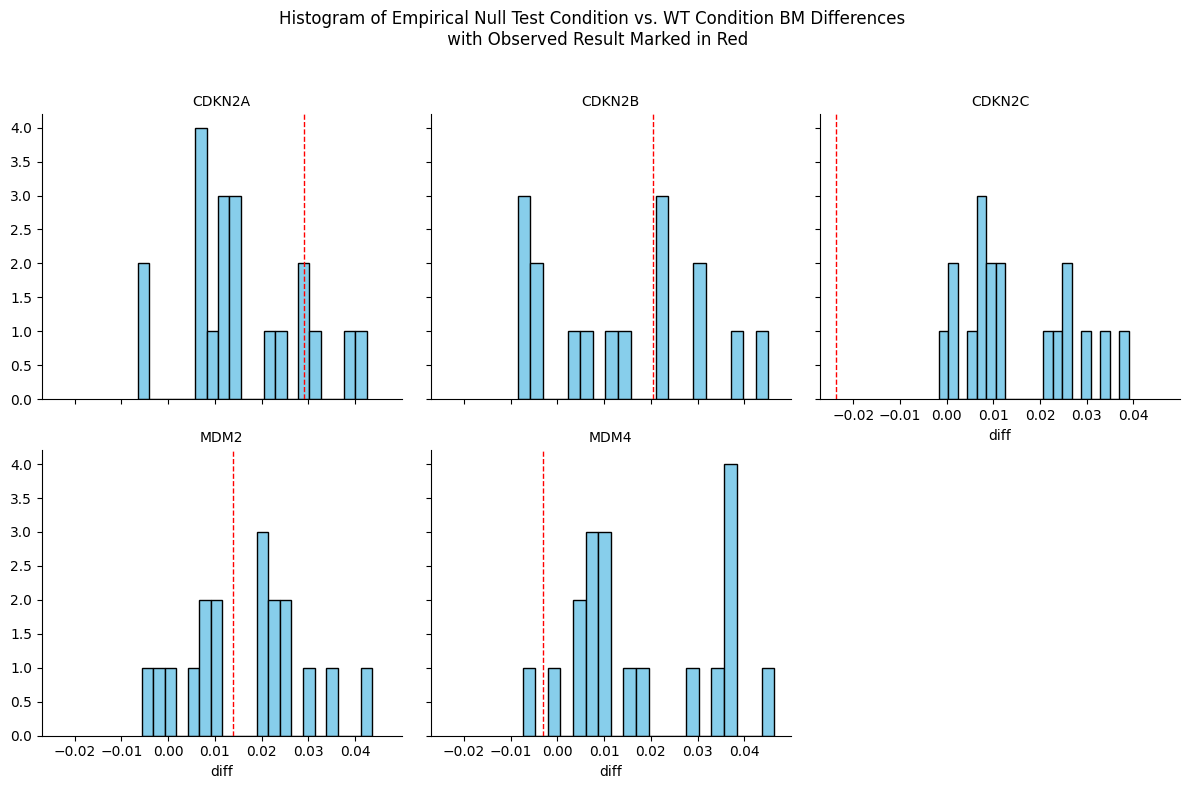

In [89]:
def plot_empirical_null_histogram(df, gene_column='gene'):
    """
    Plot histograms of 'empirical_null' diff values faceted by gene,
    with observed values marked by vertical red lines.

    Parameters:
    - df: pandas DataFrame containing the data
    - gene_column: name of the column to use for grouping (default: 'gene')

    Returns:
    - None (displays the plot)
    """
    # Filter data for "empirical_null" result_type
    df_empirical_null = df[df['result_type'] == 'empirical_null']

    # FacetGrid with seaborn
    g = sns.FacetGrid(df_empirical_null, col=gene_column, col_wrap=3, height=4)

    # Plot histogram for each gene
    g.map(plt.hist, 'diff', bins=20, color='skyblue', edgecolor='black')

    # Add a vertical red line for the "observed" value in each facet
    for ax, gene in zip(g.axes.flat, df_empirical_null[gene_column].unique()):
        observed_diff = df[(df[gene_column] == gene) & (df['result_type'] == 'observed')]['diff'].values[0]
        ax.axvline(x=observed_diff, color='red', linestyle='--', linewidth=1)

    # Adjust layout and display plot
    g.set_titles("{col_name}")
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Histogram of Empirical Null Test Condition vs. WT Condition BM Differences \n with Observed Result Marked in Red')
    plt.show()

# Example usage:
# Assuming df is your pandas DataFrame with the provided data
plot_empirical_null_histogram(p53_lof_permuted_null, gene_column='gene')
